# Прогнозирование стоимости автомобиля по их характеристикам: классический ML, текстовый анализ и обработка фотографий

**Цель:** предсказать стоимость автомобиля с помощью интеграционного подхода: объединить классническое машинное обучение (предсказание по переменным табличного виде), обработку естественного языка (текстовый анализ описания автомобиля), а также применить технихи computer vision (image processing - фотографии автомобилей).

**Step-by-step:**

* Построим "наивную"/baseline модель, предсказывающую цену по модели и году выпуска (с ней будем сравнивать другие модели)
* Обработаем и отнормируем признаки
* Сделаем первую модель на основе градиентного бустинга с помощью CatBoost
* Сделаем вторую модель на основе нейронных сетей и сравним результаты
* Сделаем multi-input нейронную сеть для анализа табличных данных и текста одновременно
* Добавим в multi-input сеть обработку изображений
* Осуществим ансамблирование градиентного бустинга и нейронной сети (усреднение их предсказаний)


## Подготовка к началу работы, установка библиотек

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
!pip install -q tensorflow==2.3 folium==0.2.1

#аугментации изображений
!pip install albumentations catboost pymorphy2 -q 

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [6]:
import random
import numpy as np 
import pandas as pd 
import os
import sys
import PIL
import cv2
import re

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

#plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

#версии библиотек
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

!pip freeze > requirements.txt

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


Задаем функцию для подсчета MAPE (Mean Absolute Percentage Error):

In [7]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

## Обработка и анализ данных: изучаем датасет

Описание данных:

Данные представляют из себя набор характеристик автомобилей, выставленных на продажу: тип кузова, дата выпуска модели, объем двиагателя, описание и т.д. Целевая переменная - price - цена автомобиля в рублях. Также есть фотографии выставляемых на продажу автомобилей.

**Типы признаков:**

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [8]:
useGoogle = False

In [9]:
# Google
if useGoogle:
  from google.colab import drive
  drive.mount('/content/drive')

In [10]:
if useGoogle:
  !ls "/content/drive/MyDrive/Colab Notebooks/Project/NewProject/sf-dst-car-price-prediction-part2"

In [11]:
DEFAULT_DIR = "../input" if not useGoogle else "/content/drive/MyDrive/Colab Notebooks/Project/NewProject"
DATA_DIR = '{}/sf-dst-car-price-prediction-part2'.format(DEFAULT_DIR)
train = pd.read_csv(DATA_DIR + '/train.csv')
test = pd.read_csv(DATA_DIR + '/test.csv')
sample_submission = pd.read_csv(DATA_DIR + '/sample_submission.csv')

**Информация о датасетах:**

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [16]:
train.nunique() #количество уникальных значений в переменных

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

## Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. C ней будем сравнивать другие модели.

In [12]:
# разбиение данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [13]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


### Таким образом,наивная модель ошибается примерно в 20% случаев. Это тот результат метрики, от которого будем отталкиваться.

## Эксплораторный анализ данных

Посмотрим, как выглядят распределения числовых признаков:

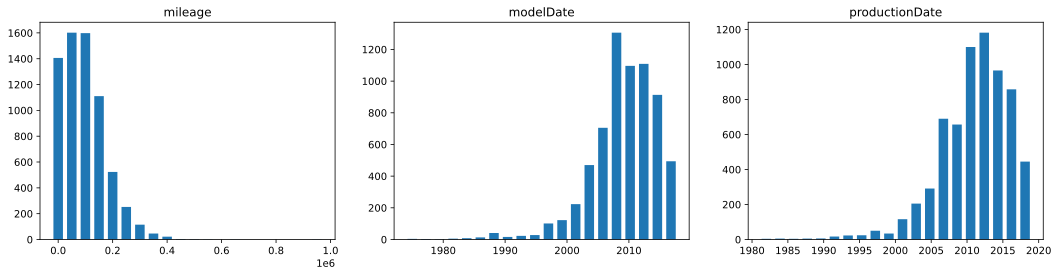

In [14]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna()
})

Видим, что числовые признаки `mileage`, `modelDate`, `productionDate` распределены не нормально. CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.

## Предобработка данных

In [15]:
#используем все текстовые признаки как категориальные без предобработки
categorical_features = ['bodyType', 'brand', 'color', 'fuelType', 'model_info', 'feature_1',
  'numberOfDoors', 'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод', 'Руль']

#используем все числовые признаки
numerical_features = ['mileage', 'modelDate_log', 'productionDate', 'last_owner', 'power', 'volume',]

#для удаления
drop_columns = ['vehicleConfiguration', 'Владение', 'modelDate', 'enginePower', 'engineDisplacement', 'name', ]

In [16]:
# Для корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [17]:
#inspired by vTchel
def get_last_owner(x):
    """Возвращает количество месяцев владения последнего владельца"""
    try:
        if str(x['Владение']).lower() == 'nan':
            if x['Владельцы'] == 1:
                return (2020 - x['productionDate'])*12 + 9
            else:
                return 1
        else:
            if '{' in str(x['Владение']):
                last = yaml.safe_load(str(x['Владение']))
                return (2020 - last.get('year')) * 12 + (9 - last.get('month', 1))
            else:
                last = re.findall(r'\d+', str(x['Владение']))
                if 'и' in str(x['Владение']):
                    res = int(last[0])*12 + int(last[1])
                elif 'л' in str(x['Владение']) or 'г' in str(x['Владение']):
                    res = int(last[0])*12
                elif 'м' in str(x['Владение']):
                    res = int(last[0])
                else:
                    res = 999999
                return res
    except Exception as err:
        print(err)
        print(x)
        print(str(x['Владение']))
        raise err

Посмотрим на распределение целевой переменной:

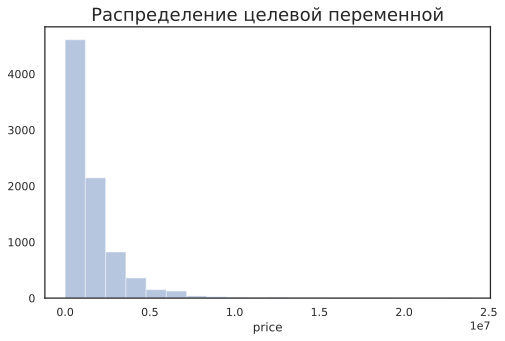

In [18]:
import seaborn as sns
sns.set(style="white")
plt.figure(figsize=(8, 5))
plt.title('Распределение целевой переменной', fontsize=18)

sns.distplot(data['price'], kde=False, bins=20);

In [19]:
def preproc_data(df_input):
    '''Функции для предобработки данных'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['description','sell_id',], axis = 1, inplace=True)

    df_output['last_owner'] = df_output[['Владельцы', 'Владение', 'productionDate']].apply(get_last_owner, axis=1)
    df_output['last_owner'] = df_output['last_owner'] + 1
    df_output['modelDate_log'] = np.log(2020 - df_output['modelDate'])
    df_output['productionDate_log'] = np.log(2020 - df_output['productionDate']+1)
    df_output['power'] = df_output['enginePower'].apply(lambda x: int(x.split(' ')[0]))
    df_output['volume'] = df_output['engineDisplacement'].apply(lambda x: float(x.split(' ')[0]) if x.split(' ')[0] != 'undefined' else 0)

    df_output['xDrive'] = df_output['name'].apply(lambda x: 1 if 'xDrive' in str(x) else 0)
    df_output['sDrive'] = df_output['name'].apply(lambda x: 1 if 'sDrive' in str(x) else 0)

    df_output['name'] = df_output['name'].apply(lambda x: str(x).replace('xDrive', ''))
    df_output['name'] = df_output['name'].apply(lambda x: str(x).replace('sDrive', ''))

    df_output['name'] = df_output['name'].apply(lambda x: str(x).replace('  ', ' '))

    df_output['feature_1'] = df_output.name.apply(lambda x: x.split(' ')[0])
    
    # ################### Количественные переменные ############################################################## 
    # Далее заполняем пропуски
    for column in numerical_features:
        df_output[column].fillna(df_output[column].median(), inplace=True)
        
    df_output['mileage'] = df_output['mileage'] ** 2
    
    # Нормализация данных
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    
    # ################### Категориальные переменные ############################################################## 
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)
    

    # ################### Очистка #################################################### 
    # убираем признаки которые еще не успели обработать, 
    df_output.drop(drop_columns, axis = 1, inplace=True)
    
    return df_output

In [20]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

,mileage,productionDate,sample,price,last_owner,modelDate_log,productionDate_log,power,volume,xDrive,...,Владельцы_0,Владельцы_1,Владельцы_2,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1
7399,0.011449,0.868421,1,1590000.0,0.158192,0.460391,1.791759,0.2720,0.303030,1,...,1,0,0,0,1,0,0,1,1,0
4273,0.002025,0.894737,1,3100000.0,0.081921,0.500000,1.609438,0.2720,0.303030,0,...,1,0,0,0,1,0,0,1,1,0
3362,0.003025,0.868421,1,3750000.0,0.000000,0.500000,1.791759,0.8160,0.833333,0,...,0,0,1,0,1,0,0,1,1,0
2794,0.015625,0.763158,1,1990000.0,0.000000,0.564575,2.302585,0.2720,0.454545,0,...,0,0,1,0,1,0,0,1,1,0
5378,0.022201,0.868421,1,1285000.0,0.000000,0.500000,1.791759,0.2288,0.303030,1,...,0,0,1,0,1,0,0,1,1,0
5902,0.004872,0.815789,1,3399999.0,0.000000,0.534311,2.079442,0.7760,0.606061,0,...,1,0,0,0,1,0,0,1,1,0
1454,0.002784,0.868421,0,0.0,0.000000,0.534311,1.791759,0.3920,0.454545,1,...,0,1,0,0,1,0,0,1,1,0
2476,0.030102,0.684211,1,700000.0,0.115819,0.659062,2.564949,0.2288,0.378788,0,...,0,0,1,1,0,1,0,0,1,0
743,0.014400,0.736842,0,0.0,0.000000,0.659062,2.397895,0.0640,0.242424,0,...,0,0,1,0,1,1,0,0,1,0
1168,0.001296,0.842105,0,0.0,0.000000,0.534311,1.945910,0.7504,0.833333,0,...,0,0,1,0,1,0,0,1,1,0


Снова посмотрим на числовые данные:

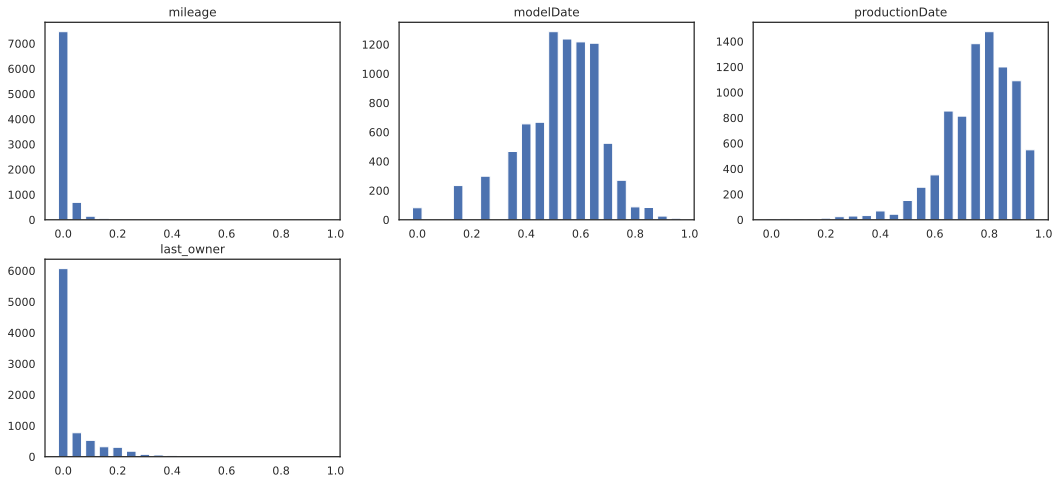

In [21]:
visualize_distributions({
    'mileage': df_preproc['mileage'].dropna(),
    'modelDate': df_preproc['modelDate_log'].dropna(),
    'productionDate': df_preproc['productionDate'].dropna(),
    'last_owner': df_preproc['last_owner'].dropna()
})

In [22]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

Значимость числовых признаков:

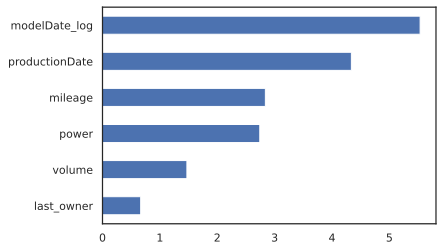

In [23]:
from sklearn.feature_selection import f_classif, mutual_info_classif

imp_num = pd.Series(f_classif(df_preproc[numerical_features],
                              df_preproc['price'])[0], index=numerical_features)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh');

## Classic ML model: CatBoostRegressor

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [25]:
model = CatBoostRegressor(iterations = 5000,
                          depth=10,
                          learning_rate = 0.01,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         )

0:	learn: 0.9963210	test: 1.0207829	best: 1.0207829 (0)	total: 89.8ms	remaining: 7m 28s
100:	learn: 0.4759666	test: 0.4848205	best: 0.4848205 (100)	total: 2.44s	remaining: 1m 58s
200:	learn: 0.2834381	test: 0.2878484	best: 0.2878484 (200)	total: 4.85s	remaining: 1m 55s
300:	learn: 0.2198845	test: 0.2238537	best: 0.2238042 (299)	total: 7.49s	remaining: 1m 56s
400:	learn: 0.2027706	test: 0.2070124	best: 0.2069992 (398)	total: 9.71s	remaining: 1m 51s
500:	learn: 0.1868918	test: 0.1912034	best: 0.1912034 (500)	total: 12.5s	remaining: 1m 51s
600:	learn: 0.1754263	test: 0.1804565	best: 0.1804543 (598)	total: 14.8s	remaining: 1m 48s
700:	learn: 0.1664091	test: 0.1724513	best: 0.1724513 (700)	total: 17.3s	remaining: 1m 45s
800:	learn: 0.1593264	test: 0.1660958	best: 0.1660958 (800)	total: 19.5s	remaining: 1m 42s
900:	learn: 0.1535343	test: 0.1610120	best: 0.1610120 (900)	total: 21.9s	remaining: 1m 39s
1000:	learn: 0.1492236	test: 0.1575193	best: 0.1575193 (1000)	total: 24.2s	remaining: 1m 36s


In [26]:
test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

TEST mape: 12.46%


### Обучив модель СatBoost видим, что ошибка (MAPE) упала почти с 20% до 12.5% и это уже неплохой результат.

### Submission

In [27]:
sub_predict_catboost = model.predict(X_sub)
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

## Следующая итерация в моделировании: Tabular NN

Построим обычную сеть:

## Simple Dense NN

In [29]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               216064    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 347,649
Trainable params: 347,649
Non-trainable params: 0
_________________________________________________________________


In [31]:
# Компилируем модель
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [32]:
checkpoint = ModelCheckpoint('./best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Checking model fit

In [33]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

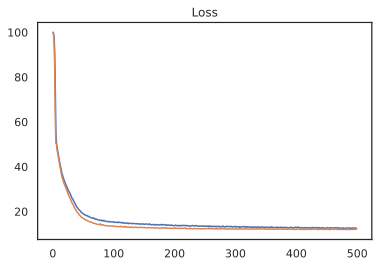

In [34]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [35]:
!ls ./

__notebook_source__.ipynb  catboost_info	    requirements.txt
best_model.hdf5		   catboost_submission.csv


In [36]:
model.load_weights('./best_model.hdf5')
model.save('./nn_1.hdf5')

In [37]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 12.32%


### Итак, видим, что простая нейронная сеть дает результат чуть лучше (MAPE = 12.3%), чем CatBoost.

In [39]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

## Продолжаем дорабатывать модель: подключаем NLP + Multiple Inputs

Посмотрим на описание автомобилей в объявлении:

In [40]:
data.description.head(10)

0    Всем привет!\n\nПродам эксклюзивный проект 124...
1    Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2    Машина тут продаётся не в первый раз, НО! Толь...
3    Автомобиль в отличном состоянии, весь в родной...
4    Немка! с бесключивым доступом и камерой заднег...
5    Добрый день, продаю свой автомобиль. Перекупам...
6    Внимание! Только для клиентов AVILON Автомобил...
7    Шикарный авто, а салон не побоюсь этого слова ...
8    Продаю Ауди А5, машина 2014 года выпуска, купл...
9    [Smart]\nОригинал ПТС, По факту один владелец,...
Name: description, dtype: object

Токенизируем/лемматизируем слова. 

**Токенизация** - процесс выделения только основной части слова.

**Лемматизация** - процесс превращения слов в их начальную форму.

In [41]:
# TOKENIZER -- токенизируем слова (выделим только основную часть слова)
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [42]:
import pymorphy2
import nltk
morph = pymorphy2.MorphAnalyzer()
from nltk.corpus import stopwords
from string import punctuation
nltk.download("stopwords")
russian_stopwords = stopwords.words("russian")

def lemmatize(text):
    text = str(text).replace(chr(8226), '')
    text = str(text).replace('..', '.')
    list_of_terms = nltk.word_tokenize(text)
    words = ["%s" % term for term in list_of_terms]
    res = list()
    res = ' '.join([morph.parse(word)[0].normal_form for word in words if word not in russian_stopwords\
          and word != " " \
          and word.strip() not in punctuation])
    return res

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [43]:
data.description.head(5).apply(lemmatize)

0    весь привет продать эксклюзивный проект 124 ун...
1    продавать любимый тачил обвес тюнинг hamman по...
2    машина продаваться первый но только перебрать ...
3    автомобиль отличный состояние весь родный крас...
4    немка бесключивый доступ камера задний вид авт...
Name: description, dtype: object

In [44]:
data.description = data.description.apply(lemmatize)

In [45]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

### Tokenizer - токенизируем

In [48]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

CPU times: user 1.32 s, sys: 3.64 ms, total: 1.32 s
Wall time: 1.32 s


Список слов:

In [55]:
#tokenize.word_index

In [56]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 1.31 s, sys: 10.7 ms, total: 1.32 s
Wall time: 1.32 s


Посмотрим как теперь выглядит текст в данных:

In [62]:
print(text_train.iloc[6])
print('  ')
print(text_train_sequences[6])

автомобиль проверить 110 пункт автокредит специальный ставка 13,7 ауди центр север официальный дилер audi входящий группа компания рольф являться один крупный дилер европа предлагать вы ряд услуга покупка продажа автомобиль пробег на протяжение многий год наш дилерский центр являться лидер продажа автомобиль пробег среди дилер audi россия предоставлять клиент самый большой выбор автомобиль пробег audi другой марка каждый автомобиль проходить тщательный диагностик подготовка гарантировать находиться отличный состояние чтобы убедиться правильный выбор вы возможность пройти тест-драйв ― ознакомительный поездка интересовать автомобиль вы смочь ознакомиться автомобиль выходить дом – наш менеджер провести online презентация видеозвонок показать выбрать автомобиль также ауди центр север представлять уникальный предложение кредитование автомобиль пробег индивидуальный условие специалист компания подобрать вы хороший условие кредитование более 6 000 проверить автомобиль пробег гарантия 2 год жд

### RNN (Recurrent Neural Network) NLP

Теперь построим модель:

In [63]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

In [64]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

### Multiple Inputs NN

Объединяем классический ML и обработку текстов:

In [65]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [66]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     6423552     seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding[0][0]                  
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 256, 256)     0           lstm[0][0]                       
_______________________________________________________________________________________

### Checking model fit

In [67]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [68]:
checkpoint = ModelCheckpoint('./best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [69]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 4s 341ms/step - loss: 99.9872 - MAPE: 99.9872 - val_loss: 99.8507 - val_MAPE: 99.8507
Epoch 2/500
12/12 [==============================] - 3s 264ms/step - loss: 98.6976 - MAPE: 98.6976 - val_loss: 94.1349 - val_MAPE: 94.1349
Epoch 3/500
12/12 [==============================] - 3s 262ms/step - loss: 80.6150 - MAPE: 80.6150 - val_loss: 53.1331 - val_MAPE: 53.1331
Epoch 4/500
12/12 [==============================] - 3s 260ms/step - loss: 53.8099 - MAPE: 53.8099 - val_loss: 49.5443 - val_MAPE: 49.5443
Epoch 5/500
12/12 [==============================] - 3s 258ms/step - loss: 48.4865 - MAPE: 48.4865 - val_loss: 46.1241 - val_MAPE: 46.1241
Epoch 6/500
12/12 [==============================] - 3s 259ms/step - loss: 44.7335 - MAPE: 44.7335 - val_loss: 42.3854 - val_MAPE: 42.3854
Epoch 7/500
12/12 [==============================] - 3s 287ms/step - loss: 41.3177 - MAPE: 41.3177 - val_loss: 38.8819 - val_MAPE: 38.8819
Epoch 8/500
12/12 [========

Обучение остановилось на 92 итерации из 500, посмотрим на прогресс обучения на графике:

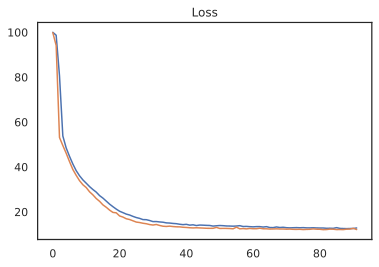

In [70]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [71]:
model.load_weights('./best_model.hdf5')
model.save('./nn_mlp_nlp.hdf5')

In [72]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 12.12%


### Видим, что с добавлением текстов ошибка MAPE упала до 12.1%

In [73]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

## Следующая модификация модели: добавляем картинки

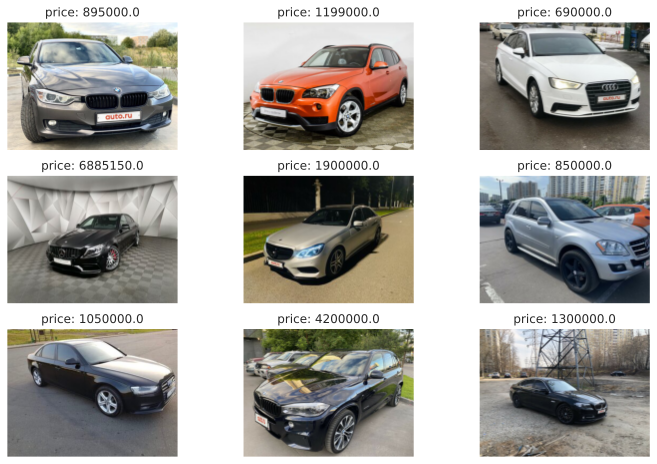

In [74]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'/img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [75]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + '/img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


## Аугментация изображений: используем библиотеку `albumentations`

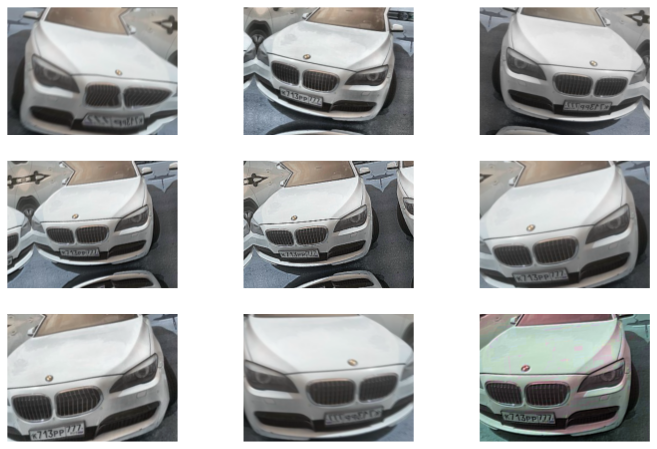

In [76]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


#пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [77]:
def make_augmentations(images):
  print('применение аугментаций', end = '')
  augmented_images = np.empty(images.shape)
  for i in range(images.shape[0]):
    if i % 200 == 0:
      print('.', end = '')
    augment_dict = augmentation(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
  print('')
  return augmented_images

### Информация про tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).

In [79]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [80]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
  return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Строим сверточную сеть для анализа изображений без "головы"

In [81]:
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

43941888/43941136 [==============================] - 1s 0us/step


In [82]:
#строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])

In [83]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
    ])

In [84]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [85]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [86]:
checkpoint = ModelCheckpoint('./best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [90]:
history = model.fit(train_dataset.batch(30),
                    epochs=10,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/10
190/190 [==============================] - 129s 677ms/step - loss: 25.8453 - MAPE: 25.8453 - val_loss: 22.4538 - val_MAPE: 22.4538
Epoch 2/10
190/190 [==============================] - 127s 670ms/step - loss: 19.9943 - MAPE: 19.9943 - val_loss: 16.6806 - val_MAPE: 16.6806
Epoch 3/10
190/190 [==============================] - 128s 671ms/step - loss: 17.7505 - MAPE: 17.7505 - val_loss: 14.8482 - val_MAPE: 14.8482
Epoch 4/10
190/190 [==============================] - 126s 666ms/step - loss: 16.1016 - MAPE: 16.1016 - val_loss: 14.8172 - val_MAPE: 14.8172
Epoch 5/10
190/190 [==============================] - 127s 667ms/step - loss: 15.4140 - MAPE: 15.4140 - val_loss: 17.7940 - val_MAPE: 17.7940
Epoch 6/10
190/190 [==============================] - 127s 667ms/step - loss: 14.8776 - MAPE: 14.8776 - val_loss: 14.2388 - val_MAPE: 14.2388
Epoch 7/10
190/190 [==============================] - 126s 665ms/step - loss: 14.6602 - MAPE: 14.6602 - val_loss: 13.1937 - val_MAPE: 13.1937
Epoch 

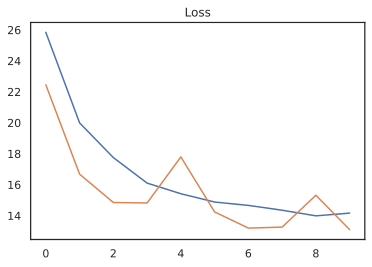

In [91]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [92]:
model.load_weights('./best_model.hdf5')
model.save('./nn_final.hdf5')

In [93]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 13.09%


### Ошибка стала чуть выше по сравнению с предыдущей моделью

In [94]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)

# Blend

In [95]:
blend_predict = (test_predict_catboost + test_predict_nn3[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 11.27%


### Видим,что blend двух моделей: CatBoost и последней обученной дает наилучший результат MAPE = 11.3%

In [96]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

## Bonus: проброс признака

In [97]:
# MLP
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

Пробрасываем дату выпуска модели для лучшего предсказания:

In [98]:
# FEATURE Input
# Iput  modelDate_log
# productiondate = L.Input(shape=[1], name="productiondate")
modelDate_log = L.Input(shape=[1], name="modelDate_log")
# mileage = L.Input(shape=[1], name="mileage")
# power = L.Input(shape=[1], name="power")
# Embeddings layers
# emb_productiondate = L.Embedding(len(X.productionDate.unique().tolist())+1, 20)(productiondate)
emb_modelDate_log = L.Embedding(len(X.modelDate_log.unique().tolist())+1, 20)(modelDate_log)
# emb_mileage = L.Embedding(len(X.mileage.unique().tolist())+1, 20)(mileage)
# emb_power = L.Embedding(len(X.power.unique().tolist())+1, 20)(power)
# f_productiondate = L.Flatten()(emb_productiondate)
f_modelDate_log = L.Flatten()(emb_modelDate_log)
# f_mileage = L.Flatten()(emb_mileage)
# f_power = L.Flatten()(emb_power)

In [99]:
combinedInput = L.concatenate([model_mlp.output, f_modelDate_log])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
# head = L.Dropout(0.25)(head)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp.input, modelDate_log ], outputs=head)

In [100]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_13_input (InputLayer)     [(None, 421)]        0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 512)          216064      dense_13_input[0][0]             
__________________________________________________________________________________________________
dropout_11 (Dropout)            (None, 512)          0           dense_13[0][0]                   
__________________________________________________________________________________________________
modelDate_log (InputLayer)      [(None, 1)]          0                                            
_______________________________________________________________________________________

In [101]:
optimizer = tf.keras.optimizers.Adam(0.0025)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [102]:
history = model.fit([X_train, X_train.modelDate_log.values ], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([X_test, X_test.modelDate_log.values ], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 0s 22ms/step - loss: 99.9997 - MAPE: 99.9997 - val_loss: 99.9982 - val_MAPE: 99.9982
Epoch 2/500
12/12 [==============================] - 0s 9ms/step - loss: 99.9906 - MAPE: 99.9906 - val_loss: 99.9636 - val_MAPE: 99.9636
Epoch 3/500
12/12 [==============================] - 0s 8ms/step - loss: 99.8873 - MAPE: 99.8873 - val_loss: 99.6787 - val_MAPE: 99.6787
Epoch 4/500
12/12 [==============================] - 0s 8ms/step - loss: 99.2836 - MAPE: 99.2836 - val_loss: 98.3493 - val_MAPE: 98.3493
Epoch 5/500
12/12 [==============================] - 0s 8ms/step - loss: 96.9645 - MAPE: 96.9645 - val_loss: 93.9936 - val_MAPE: 93.9936
Epoch 6/500
12/12 [==============================] - 0s 9ms/step - loss: 90.2939 - MAPE: 90.2939 - val_loss: 82.7245 - val_MAPE: 82.7245
Epoch 7/500
12/12 [==============================] - 0s 8ms/step - loss: 74.5397 - MAPE: 74.5397 - val_loss: 60.6676 - val_MAPE: 60.6676
Epoch 8/500
12/12 [=====================

In [103]:
model.load_weights('./best_model.hdf5')
test_predict_nn_bonus = model.predict([X_test, X_test.productionDate.values, X_test.modelDate_log.values ])
print(f"TEST mape: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")

TEST mape: 12.63%


## Краткий вывод:

### * В процессе работы над проектом реализовались следующие модели:
1. Наивная модель, предсказывает среднее значение цены по модели и году выпуска
2. Модель с использованием классического ML: CatBoostRegressor
3. Простая нейронная сеть
4. Модель нейронной сети с добавлением NLP по опписанию автомобиля (Multiple Inputs)
5. Модель нейронной сети с image processing фотографий автомобилей
6. Модель Blend, объединяющую CatBoost и NN c добавленной обработкой изображений (**лучшая**)
7. Модель с пробросом признака по году выпуска автомобиля

### * Видим, что ошибка в последней модели с пробросом признака выше, чем в просто Blend модели. Таким образом, будем использовать Blend модель для финального сабмита на соревновании. 

### * **Итоговая метрика MAPE на Kaggle: 12.26%**